In [5]:
# test on the order of the lmdb file:
import lmdb
import os
import pickle
def write_lmdb(data, lmdb_path):
    env = lmdb.open(lmdb_path, subdir=False, readonly=False, lock=False, readahead=False, meminit=False, max_readers=32, map_size=int(10e9))
    with env.begin(write=True) as txn:
        for i, d in tqdm(enumerate(data)):
            txn.put(str(i).encode(), pickle.dumps(d))
    env.close()


In [3]:
import lmdb
import os
from tqdm import tqdm
import pickle
def read_lmdb(lmdb_path, mode="idx"):
    """
    Read lmdb file.

    Args:
        lmdb_path (str): Path to the lmdb file.
        mode (str, optional): Read mode. "idx" to follow the idx order, "direct" to read the data directly (use when idx is not continuous).

    Returns:
        list: List of data read from the lmdb file.
    """
    env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False,
        max_readers=256,
    )
    pocket_name_cnt = {}
    smi_cnt={}
    pocket_smi_pair_cnt={}
    txn = env.begin()
    keys = list(txn.cursor().iternext(values=False))
    data_all = []
    if mode == "idx":
        for idx in tqdm(range(len(keys)), desc="read lmdb {}".format(lmdb_path)):
            ky=f'{idx}'.encode()
            datapoint_pickled = txn.get(ky)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append(data_piece)
            smi=data_piece['smi']
            pocket_name=data_piece['pocket_name']
            pocket_smi_pair=(smi, pocket_name)
            smi_cnt[smi]=smi_cnt.get(smi, 0)+1
            pocket_name_cnt[pocket_name]=pocket_name_cnt.get(pocket_name, 0)+1
            pocket_smi_pair_cnt[pocket_smi_pair]=pocket_smi_pair_cnt.get(pocket_smi_pair, 0)+1
    elif mode == "direct":
        for key in tqdm(keys, desc="read lmdb {}".format(lmdb_path)):
            datapoint_pickled = txn.get(key)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append(data_piece)
    return data_all, smi_cnt, pocket_name_cnt, pocket_smi_pair_cnt

crossdocked_path = '/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb'
crossdocked_list=read_lmdb(crossdocked_path,mode="direct")[0]


read lmdb /nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb: 100%|██████████| 166500/166500 [17:57<00:00, 154.45it/s] 


In [11]:
import torch
split_path="/nfs/data/targetdiff_data/crossdocked_pocket10_pose_split.pt"
split=torch.load(split_path)
split_name={}
for (name,split) in split.items():
    ret=[]
    for item in split:
        ret.append(crossdocked_list[item]["protein_filename"])
    split_name[name]=ret


In [19]:
print(len(split_name['val']))
# output_path="/nfs/data/targetdiff_data/crossdocked_pocket10_pose_split_by_name.pt"
# torch.save(split_name, output_path)


0


In [18]:
bowenfeat_path="/nfs/data/bowenfeat/data.mdb"
bowenfeat,smi_cnt, pocket_name_cnt, pocket_smi_pair_cnt=read_lmdb(bowenfeat_path)

read lmdb /nfs/data/bowenfeat/data.mdb: 100%|██████████| 1665000/1665000 [00:16<00:00, 99195.21it/s] 


In [22]:
print(len(smi_cnt))
# sort by the number of smi_cnt
smi_cnt_sorted=sorted(smi_cnt.items(), key=lambda x: x[1], reverse=True)
print(smi_cnt_sorted[:10])

13562
[('CCn1c(Cn2nc(C(F)F)cc2C(F)F)nnc1SCc1nc2c3cnn(C)c3ncn2n1', 64851), ('CCOCCCn1/c(=N/C(=O)c2cccc([N+](=O)[O-])c2C)c(C#N)cc2c(=O)n3ccccc3nc21', 59271), ('COc1cc(NC(N)=Nc2nc(=O)c3c([nH]2)CCCC3)cc(OC)c1', 37279), ('COc1cc(-c2nc3ccccc3c(=O)n2NC(=O)c2c(F)cccc2F)cc(OC)c1OC', 31607), ('Cc1ccc(C(=O)/N=c2\\c(C#N)cc3c(=O)n4cccc(C)c4nc3n2CCCOC(C)C)cc1[N+](=O)[O-]', 30819), ('Cc1c(C(=O)/N=c2\\c(C#N)cc3c(=O)n4ccccc4nc3n2CCCOC(C)C)cccc1[N+](=O)[O-]', 28642), ('CCn1c(SCc2nc3c4cnn(C)c4ncn3n2)nnc1-c1cc(C(F)(F)F)n(C)n1', 27354), ('CCOC1=CC(=C2C=CC(=O)C([O-])=C2)C=C(OCC)c2c(C)oc(C)c21', 26930), ('O=C(N1CCCC1)N1CC[C@@H](Oc2cc(N3CCCC3)ncn2)C1', 22917), ('CCN1C(=O)/C(=N/NC(=O)c2c(-c3ccccc3)nc3n(Cc4ccccc4)c4ccccc4n23)c2cc(C)ccc21', 21521)]


In [24]:
# max of pocket_name_cnt
pocket_name_cnt_sorted=sorted(pocket_name_cnt.items(), key=lambda x: x[1], reverse=True)
print(pocket_name_cnt_sorted[-10:])


[('NAMPT_HUMAN_1_490_0/4lv9_A_rec_2gvg_nmn_lig_tt_docked_0_pocket10.pdb', 10), ('NAMPT_HUMAN_1_490_0/4lv9_A_rec_4n9b_2hh_lig_tt_docked_6_pocket10.pdb', 10), ('ANDR_HUMAN_666_919_ligBind_0/3g0w_A_rec_2ylo_tes_lig_tt_min_0_pocket10.pdb', 10), ('NAMPT_HUMAN_1_490_0/2e5d_A_rec_2gvg_nmn_lig_tt_docked_0_pocket10.pdb', 10), ('NAMPT_HUMAN_1_490_0/2e5d_A_rec_4jnm_1lj_lig_tt_docked_0_pocket10.pdb', 10), ('NAMPT_HUMAN_1_490_0/4lv9_A_rec_4lv9_20j_lig_tt_docked_1_pocket10.pdb', 10), ('NAMPT_HUMAN_1_490_0/2e5d_A_rec_2gvj_dgb_lig_tt_docked_0_pocket10.pdb', 10), ('NAMPT_HUMAN_1_490_0/3dhf_A_rec_4lvg_20o_lig_tt_docked_5_pocket10.pdb', 10), ('NAMPT_HUMAN_1_490_0/3dhf_A_rec_4kfn_1qr_lig_tt_docked_1_pocket10.pdb', 10), ('NAMPT_HUMAN_1_490_0/4lv9_A_rec_4o10_2qf_lig_tt_docked_1_pocket10.pdb', 10)]


In [24]:
import torch
split=torch.load("/nfs/data/targetdiff_data/crossdocked_pocket10_pose_split.pt")
train_idx=split["train"]
test_idx=split["test"]
have_retfeat_cnt=0
not_have_retfeat_cnt=0
for idx in test_idx:
    if crossdocked_list[idx]["ret_feat"] is not None:
        have_retfeat_cnt+=1
    else:
        not_have_retfeat_cnt+=1
print("following the idx order:")
print("have_retfeat_cnt:",have_retfeat_cnt)
print("not_have_retfeat_cnt:",not_have_retfeat_cnt)

following the idx order:
have_retfeat_cnt: 100
not_have_retfeat_cnt: 0


In [25]:
def get_keys(lmdb_path):
    env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False,
        max_readers=256,
    )
    txn = env.begin()
    keys = list(txn.cursor().iternext(values=False))
    return keys
keys=get_keys(crossdocked_path)
print("following the keys order:")
have_retfeat_cnt=0
not_have_retfeat_cnt=0
for idx in test_idx:
    idx_of_key=keys[idx]
    idx_in_list=int(idx_of_key)
    if crossdocked_list[idx_in_list]["ret_feat"] is not None:
        have_retfeat_cnt+=1
    else:
        not_have_retfeat_cnt+=1
print("have_retfeat_cnt:",have_retfeat_cnt)
print("not_have_retfeat_cnt:",not_have_retfeat_cnt)    

following the keys order:
have_retfeat_cnt: 62
not_have_retfeat_cnt: 38


In [8]:
new_crossdocked_list=[]
add_cnt=0
for idx, item in enumerate(crossdocked_list):
    if "ret_feat" not in item:
        item["ret_feat"] = None
        add_cnt+=1
    new_crossdocked_list.append(item)
print(add_cnt)
print("len(new_crossdocked_list)", len(new_crossdocked_list))
new_crossdocked_path='/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-002.lmdb'
write_lmdb(new_crossdocked_list, new_crossdocked_path)


0
len(new_crossdocked_list) 166500


166500it [02:32, 1093.08it/s]


In [20]:
key_l=[]
for i in key_list:
    key_l.append(int(i.decode().split("\'")[1]))
key_l=sorted(key_l)
print(key_l[:300])
# find missing key
for i in range(30000):
    if i not in key_l:
        print(i)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

KeyboardInterrupt: 

In [1]:
import torch 
model = torch.load('/nfs/data/targetdiff_data/crossdocked_pocket10_pose_split.pt')



In [26]:
# test on the order of the lmdb file:
import lmdb
import os
import pickle
def write_lmdb(data, lmdb_path):
    env = lmdb.open(lmdb_path, subdir=False, readonly=False, lock=False, readahead=False, meminit=False, max_readers=32, map_size=int(10e9))
    with env.begin(write=True) as txn:
        for i, d in tqdm(data):
            txn.put(str(i).encode(), pickle.dumps(d))
    env.close()

data=[(123,"data123"),(456,"data456"),(789,"data789"),(1,"data1")]
lmdb_path="/nfs/data/targetdiff_data/tmp_lmdb.lmdb"
write_lmdb(data, lmdb_path)

100%|██████████| 4/4 [00:00<00:00, 20116.57it/s]


In [36]:
env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False,
        max_readers=256,
    )
txn = env.begin()
keys = list(txn.cursor().iternext(values=False))
print(keys)
new_data=[]
for key in keys:
    print("key:",key)
    datapoint_pickled = txn.get(key)
    data_piece = pickle.loads(datapoint_pickled)
    print("data_piece:",data_piece)
    new_data.append((key,data_piece))
print(data)

[b'1', b'123', b'456', b'789']
key: b'1'
data_piece: data1
key: b'123'
data_piece: data123
key: b'456'
data_piece: data456
key: b'789'
data_piece: data789
[(123, 'data123'), (456, 'data456'), (789, 'data789'), (1, 'data1')]


In [25]:
#############################################################
# this script is used to inject bowenfeat into crossdock dataset
# the bowenfeat is generated from the retrieval augmented pipeline
# the crossdock dataset is saved in /nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb
# the crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb has been backed up to crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb.backup


import os
import pickle
import random

import lmdb
import numpy as np
from tqdm import tqdm


def read_lmdb(lmdb_path, mode="idx"):
    """
    Read lmdb file.

    Args:
        lmdb_path (str): Path to the lmdb file.
        mode (str, optional): Read mode. "idx" to follow the idx order, "direct" to read the data directly (use when idx is not continuous).

    Returns:
        list: List of data read from the lmdb file.
    """
    env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False,
        max_readers=256,
    )
    txn = env.begin()
    keys = list(txn.cursor().iternext(values=False))
    data_all = []
    if mode == "idx":
        for idx in tqdm(range(len(keys)), desc="read lmdb {}".format(lmdb_path)):
            ky=f'{idx}'.encode()
            datapoint_pickled = txn.get(ky)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append(data_piece)
    elif mode == "direct":
        for key in tqdm(keys, desc="read lmdb {}".format(lmdb_path)):
            datapoint_pickled = txn.get(key)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append((int(key), data_piece))
    return data_all



crossdocked_path = '/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb.backup'
new_crossdocked_path = '/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb'
if os.path.exists(new_crossdocked_path):
    os.remove(new_crossdocked_path)


crossdocked_list=read_lmdb(crossdocked_path,mode="direct")

# (protein_name,lignad_name) -> ret_feat : a list of 1024-dim np.array
name_to_feat={}


##########################################################
## this is to inject the old version of bowenfeat, which is saved in two separate lmdb files: bowenfeat_train and bowenfeat_test
##########################################################
# queue=["train_processed","test_processed"]
# bowenfeat = ["/nfs/data/bowenfeat/bowenfeat_train/data.mdb","/nfs/data/bowenfeat/bowenfeat_test/data.mdb"]
# ret_topk=[10,100]
# processed_path="/nfs/data/targetdiff_data/"
# for dataset_idx,dataset in enumerate(queue):
#     dataset_path=processed_path+dataset+".lmdb"
#     print("dataset_path: ", dataset_path)
#     data_list = read_lmdb(dataset_path)
#     ret_feat_list = read_lmdb(bowenfeat[dataset_idx])
#     assert len(data_list)*ret_topk[dataset_idx]==len(ret_feat_list)
#     for idx,data_piece in enumerate(data_list):
#         key=(data_piece["protein_name"],data_piece["ligand_name"])
#         assert key not in name_to_feat
#         name_to_feat[key]=[]
#         for i in range(ret_topk[dataset_idx]):
#             name_to_feat[key].append(ret_feat_list[idx*10+i])

bowenfeat_path="/nfs/data/bowenfeat/data.mdb"
bowenfeat_list=read_lmdb(bowenfeat_path)
ret_feat_map={}
for data_piece in bowenfeat_list:
    pocket_name=data_piece["pocket_name"]
    feat=data_piece["feat"]
    if pocket_name not in ret_feat_map:
        ret_feat_map[pocket_name]=[]
    ret_feat_map[pocket_name].append(feat)
for key in ret_feat_map.keys():
    assert len(ret_feat_map[key])==10
    ret_feat_map[key]=np.array(ret_feat_map[key])



read lmdb /nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb.backup: 100%|██████████| 166500/166500 [02:35<00:00, 1070.45it/s]
read lmdb /nfs/data/bowenfeat/data.mdb: 100%|██████████| 1665000/1665000 [00:14<00:00, 111241.25it/s]


In [34]:
protein_name_cnt={}
for (_,data_piece) in crossdocked_list:
    protein_name=data_piece["protein_filename"]
    protein_name_cnt[protein_name]=protein_name_cnt.get(protein_name,0)+1
protein_name_cnt=sorted(protein_name_cnt.items(), key=lambda x: x[1], reverse=True)
print(protein_name_cnt[-10:])



[('FA10_HUMAN_126_476_0/1nfy_B_rec_1iqm_xmk_lig_tt_docked_1_pocket10.pdb', 1), ('FA10_HUMAN_126_476_0/4y6d_B_rec_1nfy_rtr_lig_tt_docked_2_pocket10.pdb', 1), ('FA10_HUMAN_126_476_0/4y6d_B_rec_2p93_me1_lig_tt_docked_0_pocket10.pdb', 1), ('BRPF1_HUMAN_625_740_0/5ffy_A_rec_5fg5_5xf_lig_tt_docked_0_pocket10.pdb', 1), ('FA10_HUMAN_126_476_0/2vvc_B_rec_2xbv_xbv_lig_tt_docked_0_pocket10.pdb', 1), ('FA10_HUMAN_126_476_0/4y6d_B_rec_1lpz_cmb_lig_tt_docked_0_pocket10.pdb', 1), ('FA10_HUMAN_126_476_0/4y6d_B_rec_2j94_g15_lig_tt_docked_2_pocket10.pdb', 1), ('FA10_HUMAN_126_476_0/4y6d_B_rec_3tk5_d1q_lig_tt_docked_0_pocket10.pdb', 1), ('FA10_HUMAN_126_476_0/4y6d_B_rec_2j95_gsx_lig_tt_docked_4_pocket10.pdb', 1), ('FA10_HUMAN_126_476_0/2vvc_B_rec_2p95_me5_lig_tt_docked_0_pocket10.pdb', 1)]


In [38]:
new_crossdocked_list=[]
for idx,data_piece in tqdm(crossdocked_list):
    key=data_piece["protein_filename"]
    assert key in ret_feat_map
    data_piece["ret_feat"]=ret_feat_map[key]
    new_crossdocked_list.append((idx,data_piece))

write_lmdb(new_crossdocked_list,new_crossdocked_path,mode="direct")
print("done")

100%|██████████| 166500/166500 [02:23<00:00, 1159.99it/s]


done


In [36]:
def write_lmdb(data, lmdb_path,mode="idx"):
    env = lmdb.open(lmdb_path, subdir=False, readonly=False, lock=False, readahead=False, meminit=False, max_readers=32, map_size=int(20e9))
    if mode=="idx":
        with env.begin(write=True) as txn:
            for i, d in tqdm(enumerate(data)):
                txn.put(str(i).encode(), pickle.dumps(d))
    elif mode=="direct":
        with env.begin(write=True) as txn:
            for i, d in tqdm(data):
                txn.put(str(i).encode(), pickle.dumps(d))
    env.close()

In [14]:
import torch
from torch_geometric.data import Batch
missing_cnt=0
for i in range(100):
    try : 
        torch.load("/nfs/data/targetdiff_data/sample_output/outputs_xattn_res/result_{}.pt".format(i))
    except Exception as e:
        if "No module named \'datasets\'"  in str(e):
            # print("ok")
            pass
        elif "No such file or directory" in str(e):
            # print("ok")
            missing_cnt+=1
            print("missing:",i)
            pass
        else :
            print(i)
            print(e)
            
print("missing:",missing_cnt)


missing: 32
missing: 1


In [1]:
import torch
ckpt_path="/nfs/data/targetdiff_data/ckpts/xattn_14200.pt"
ckpt=torch.load(ckpt_path)

In [2]:
for key in ckpt["model"].keys():
    print(key)

betas
alphas_cumprod
alphas_cumprod_prev
sqrt_alphas_cumprod
sqrt_one_minus_alphas_cumprod
sqrt_recip_alphas_cumprod
sqrt_recipm1_alphas_cumprod
posterior_mean_c0_coef
posterior_mean_ct_coef
posterior_var
posterior_logvar
log_alphas_v
log_one_minus_alphas_v
log_alphas_cumprod_v
log_one_minus_alphas_cumprod_v
Lt_history
Lt_count
fusion_model.linear_query.weight
fusion_model.linear_query.bias
fusion_model.attention.in_proj_weight
fusion_model.attention.in_proj_bias
fusion_model.attention.out_proj.weight
fusion_model.attention.out_proj.bias
protein_atom_emb.weight
protein_atom_emb.bias
ligand_atom_emb.weight
ligand_atom_emb.bias
refine_net.distance_expansion.offset
refine_net.edge_pred_layer.net.0.weight
refine_net.edge_pred_layer.net.0.bias
refine_net.edge_pred_layer.net.1.weight
refine_net.edge_pred_layer.net.1.bias
refine_net.edge_pred_layer.net.3.weight
refine_net.edge_pred_layer.net.3.bias
refine_net.init_h_emb_layer.distance_expansion.offset
refine_net.init_h_emb_layer.x2h_layers.0.

In [4]:
# print config
import json
ckpt["config"]["data"]["path"]="/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10"
ckpt["config"]["data"]["split"]="/nfs/data/targetdiff_data/crossdocked_pocket10_pose_split.pt"
config_str=json.dumps(ckpt["config"], indent=4)
print(config_str)
torch.save(ckpt,ckpt_path)

{
    "data": {
        "name": "pl",
        "path": "/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10",
        "split": "/nfs/data/targetdiff_data/crossdocked_pocket10_pose_split.pt",
        "transform": {
            "ligand_atom_mode": "add_aromatic",
            "random_rot": false
        }
    },
    "model": {
        "denoise_type": "diffusion",
        "model_mean_type": "C0",
        "gt_noise_type": "origin",
        "beta_schedule": "sigmoid",
        "beta_start": 1e-07,
        "beta_end": 0.002,
        "v_beta_schedule": "cosine",
        "v_beta_s": 0.01,
        "num_diffusion_timesteps": 1000,
        "loss_v_weight": 100.0,
        "v_mode": "categorical",
        "v_net_type": "mlp",
        "loss_pos_type": "mse",
        "sample_time_method": "symmetric",
        "time_emb_dim": 0,
        "time_emb_mode": "simple",
        "center_pos_mode": "protein",
        "node_indicator": true,
        "model_type": "uni_o2",
        "num_blocks": 1,
        

torch.Size([128, 256])
torch.Size([128])


torch.Size([256])
tensor(0.0416, device='cuda:7')
tensor(0.0128, device='cuda:7')


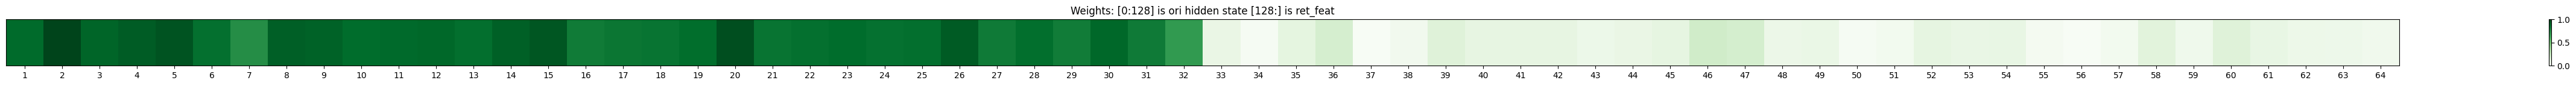

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt


# show weight
ckpt_path="/nfs/data/targetdiff_data/ckpts/cat_22200.pt"
ckpt=torch.load(ckpt_path)
linear_weight=ckpt["model"]["fusion_model.linear.weight"]
linear_bias=ckpt["model"]["fusion_model.linear.bias"]
weight_mean=torch.abs(linear_weight).mean(dim=0)
print(weight_mean.shape)
ori_h_weight=weight_mean[:128]
ret_weight=weight_mean[128:]
# print(ori_h_weight)
# print(ret_weight)
print(ori_h_weight.mean())
print(ret_weight.mean())

weight_mean_np = weight_mean.cpu().numpy()
weight_mean_np = np.mean(weight_mean_np.reshape(-1, 4), axis=1)


# pool the 128 dim weight_mean_np to 32 dim with mean pooling


scaled_weights = (weight_mean_np - np.min(weight_mean_np)) / (np.max(weight_mean_np) - np.min(weight_mean_np))

plt.figure(figsize=(len(scaled_weights), 1))
plt.imshow([scaled_weights], cmap='Greens', aspect='auto')
plt.colorbar()

plt.xticks(range(len(scaled_weights)), range(1, len(scaled_weights) + 1))
plt.yticks([])
plt.title('Weights: [0:128] is ori hidden state [128:] is ret_feat')

plt.show()

In [1]:
#############################################################
# this script is used to inject bowenfeat into crossdock dataset
# the bowenfeat is generated from the retrieval augmented pipeline
# the crossdock dataset is saved in /nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb
# the crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb has been backed up to crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb.backup


import os
import pickle
import random

import lmdb
import numpy as np
from tqdm import tqdm


def read_lmdb(lmdb_path, mode="idx"):
    """
    Read lmdb file.

    Args:
        lmdb_path (str): Path to the lmdb file.
        mode (str, optional): Read mode. "idx" to follow the idx order, "direct" to read the data directly (use when idx is not continuous).

    Returns:
        list: List of data read from the lmdb file.
    """
    env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False,
        max_readers=256,
    )
    txn = env.begin()
    keys = list(txn.cursor().iternext(values=False))
    data_all = []
    if mode == "idx":
        for idx in tqdm(range(len(keys)), desc="read lmdb {}".format(lmdb_path)):
            ky=f'{idx}'.encode()
            datapoint_pickled = txn.get(ky)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append(data_piece)
    elif mode == "direct":
        for key in tqdm(keys, desc="read lmdb {}".format(lmdb_path)):
            datapoint_pickled = txn.get(key)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append((key, data_piece))
    return data_all

def write_lmdb(data, lmdb_path,mode="idx"):
    env = lmdb.open(lmdb_path, subdir=False, readonly=False, lock=False, readahead=False, meminit=False, max_readers=32, map_size=int(30e9))
    if mode=="idx":
        with env.begin(write=True) as txn:
            for i, d in tqdm(enumerate(data)):
                txn.put(i, pickle.dumps(d))
    elif mode=="direct":
        with env.begin(write=True) as txn:
            for i, d in tqdm(data):
                txn.put(i, pickle.dumps(d))
    env.close()

crossdocked_path = '/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb.backup'
new_crossdocked_path = '/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb'

if os.path.exists(new_crossdocked_path):
    os.remove(new_crossdocked_path)
crossdocked_list=read_lmdb(crossdocked_path,mode="direct")


read lmdb /nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb.backup: 100%|██████████| 166500/166500 [07:58<00:00, 348.28it/s]


In [2]:
ret_feat_map={}
# ret_feat_path_list=["/nfs/data/targetdiff_data/ret_feat_meta/chemdiv_top100_unimol.pkl","/nfs/data/targetdiff_data/ret_feat_meta/chemdiv_top100_unimol_valid.pkl"]
ret_feat_path_list=["/nfs/data/targetdiff_data/ret_feat_meta/bindnet/ret_feat_bindnet.mdb","/nfs/data/targetdiff_data/ret_feat_meta/bindnet/ret_feat_bindnet_test.mdb"]
for ret_feat_path in ret_feat_path_list:
    ret_filetype=ret_feat_path.split(".")[-1]
    if ret_filetype=="mdb":
        bowenfeat_list=read_lmdb(ret_feat_path)
        for data_piece in bowenfeat_list:
            pocket_name=data_piece["pocket_name"]
            pocket_name=pocket_name.split(".")[0]
            pocket_name=pocket_name.replace("_pocket10","")
            feat=data_piece["feat"]
            if pocket_name not in ret_feat_map:
                ret_feat_map[pocket_name]=[]
            ret_feat_map[pocket_name].append(feat)
        for key in ret_feat_map.keys():
            assert len(ret_feat_map[key])==10
            ret_feat_map[key]=np.array(ret_feat_map[key])
    elif ret_filetype=="pkl":
        with open(ret_feat_path,"rb") as f:
            ret_feat_data=pickle.load(f)
        data_num=len(ret_feat_data['index'])
        for idx in range(data_num):
            pdb_name=ret_feat_data['index'][idx]
            feat=ret_feat_data['data'][idx]
            key=pdb_name.replace("_pocket10","").replace(".pdb","")
            if key not in ret_feat_map:
                ret_feat_map[key]=[]
            ret_feat_map[key].append(feat)
    else:
        raise NotImplementedError
for key in ret_feat_map.keys():
    assert len(ret_feat_map[key])==10
    ret_feat_map[key]=np.array(ret_feat_map[key]).astype(np.float32)

print("ret_feat_map.keys(): ", list(ret_feat_map.keys())[:10])
found_cnt=0
new_crossdocked_list=[]
for idx,data_piece in tqdm(crossdocked_list):
    key=data_piece["ligand_filename"]
    key=key.split(".")[0]
    ret_feat_key="ret_feat_bindnet"
    if key in ret_feat_map:
        data_piece[ret_feat_key]=ret_feat_map[key]
        found_cnt+=1
    else:
        data_piece[ret_feat_key]=None
    new_crossdocked_list.append((idx,data_piece))

read lmdb /nfs/data/targetdiff_data/ret_feat_meta/bindnet/ret_feat_bindnet.mdb: 100%|██████████| 999900/999900 [00:10<00:00, 96371.10it/s] 
read lmdb /nfs/data/targetdiff_data/ret_feat_meta/bindnet/ret_feat_bindnet_test.mdb: 100%|██████████| 1000/1000 [00:00<00:00, 82199.35it/s]


ret_feat_map.keys():  ['3HAO_CUPMC_1_172_0/4hvr_A_rec_1yfy_3ha_lig_tt_min_0', '3HAO_CUPMC_1_172_0/4hvr_A_rec_1yfw_4aa_lig_tt_min_0', 'BRD2_HUMAN_69_198_0/4a9i_A_rec_4alh_a9p_lig_tt_min_0', 'BRD2_HUMAN_69_198_0/4uyf_A_rec_4uyf_73b_lig_tt_min_0', 'CBPA1_BOVIN_111_418_0/1f57_A_rec_1cps_cpm_lig_tt_min_0', 'CSK21_HUMAN_1_335_ATPsite_0/3mb7_A_rec_3mb6_01i_lig_tt_docked_3', 'AAT_ECOLI_1_396_0/1art_A_rec_5vwq_pmp_lig_tt_docked_1', 'AAUA_ALCFA_57_182_0/2ah1_D_rec_2q7q_c2b_lig_tt_docked_2', 'ALBU_HUMAN_25_609_warfarinSite_0/2bxi_A_rec_5id7_pge_lig_tt_min_0', 'HYES_HUMAN_230_551_0/4od0_A_rec_4od0_2rv_lig_tt_docked_3']


100%|██████████| 166500/166500 [00:00<00:00, 228762.01it/s]


In [3]:
from tqdm import tqdm
ret_feat_map={}
ret_feat_path_list=["/nfs/data/targetdiff_data/ret_feat_meta/unimol/chemdiv_top100_unimol.pkl","/nfs/data/targetdiff_data/ret_feat_meta/unimol/chemdiv_top100_unimol_valid.pkl"]
# ret_feat_path_list=["/nfs/data/targetdiff_data/ret_feat_meta/bindnet/ret_feat_bindnet.mdb","/nfs/data/targetdiff_data/ret_feat_meta/bindnet/ret_feat_bindnet_test.mdb"]
for ret_feat_path in ret_feat_path_list:
    ret_filetype=ret_feat_path.split(".")[-1]
    if ret_filetype=="mdb":
        bowenfeat_list=read_lmdb(ret_feat_path)
        for data_piece in bowenfeat_list:
            pocket_name=data_piece["pocket_name"]
            pocket_name=pocket_name.split(".")[0]
            pocket_name=pocket_name.replace("_pocket10","")
            feat=data_piece["feat"]
            if pocket_name not in ret_feat_map:
                ret_feat_map[pocket_name]=[]
            ret_feat_map[pocket_name].append(feat)
        for key in ret_feat_map.keys():
            assert len(ret_feat_map[key])==10
            ret_feat_map[key]=np.array(ret_feat_map[key])
    elif ret_filetype=="pkl":
        with open(ret_feat_path,"rb") as f:
            ret_feat_data=pickle.load(f)
        data_num=len(ret_feat_data['index'])
        for idx in tqdm(range(data_num)):
            pdb_name=ret_feat_data['index'][idx]
            feat=ret_feat_data['data'][idx]
            key=pdb_name.replace("_pocket10","").replace(".pdb","")
            if key not in ret_feat_map:
                ret_feat_map[key]=[]
            ret_feat_map[key].append(feat)
    else:
        raise NotImplementedError
for key in ret_feat_map.keys():
    assert len(ret_feat_map[key])==100
    ret_feat_map[key]=np.array(ret_feat_map[key]).astype(np.float32)

print("ret_feat_map.keys(): ", list(ret_feat_map.keys())[:10])
crossdocked_list=new_crossdocked_list
new_crossdocked_list=[]
for idx,data_piece in tqdm(crossdocked_list):
    key=data_piece["ligand_filename"]
    key=key.split(".")[0]
    if key in ret_feat_map:
        data_piece["ret_feat_unimol"]=ret_feat_map[key]
    else:
        data_piece["ret_feat_unimol"]=None
    new_crossdocked_list.append((idx,data_piece))

100%|██████████| 10000/10000 [00:00<00:00, 540767.90it/s]


ret_feat_map.keys():  ['3HAO_CUPMC_1_172_0/4hvr_A_rec_1yfy_3ha_lig_tt_min_0', '3HAO_CUPMC_1_172_0/4hvr_A_rec_1yfw_4aa_lig_tt_min_0', 'CSK21_HUMAN_1_335_ATPsite_0/3mb7_A_rec_3mb7_14i_lig_tt_docked_6', 'CSK21_HUMAN_1_335_ATPsite_0/3u4u_A_rec_5t1h_75e_lig_tt_docked_0', 'HYSA_STRPN_286_1008_0/1f9g_A_rec_1f9g_asc_lig_tt_min_0', 'DXR_PLAF7_75_488_0/4y6s_A_rec_3au9_fom_lig_tt_min_0', 'CARP_CRYPA_90_419_catalytic_0/4y5g_A_rec_5lwr_7b2_lig_tt_min_0', 'BRD2_HUMAN_69_198_0/5hen_A_rec_4uyh_9s3_lig_tt_min_0', 'CDK2_HUMAN_1_298_0/4fkv_A_rec_1pye_pm1_lig_tt_min_0', 'DXR_PLAF7_75_488_0/3wqr_A_rec_4y67_rc5_lig_tt_min_0']


100%|██████████| 166500/166500 [00:00<00:00, 245855.43it/s]


In [4]:
new_crossdocked_list[1]

(b'1',
 {'protein_element': tensor([ 7,  6,  6,  8,  7,  6,  6,  8,  6,  6,  8,  7,  7,  6,  6,  8,  6,  8,
           6,  7,  6,  6,  8,  6,  6,  6,  7,  6,  6,  8,  6,  6,  6,  7,  6,  6,
           8,  7,  6,  6,  8,  6,  6,  8,  7,  7,  6,  6,  8,  6,  6,  6,  7,  6,
           7,  7,  7,  6,  6,  8,  6,  6,  7,  6,  6,  7,  7,  6,  6,  8,  6,  6,
           6,  8,  8,  7,  6,  6,  8,  6,  6,  6,  6,  6,  6,  6,  7,  6,  6,  8,
           6,  6,  6,  6,  7,  6,  6,  8,  6,  6,  7,  6,  6,  7,  7,  6,  6,  8,
           6,  8,  7,  6,  6,  8,  6,  6,  6,  7,  6,  6,  8,  6,  6,  6,  8,  7,
           7,  6,  6,  8,  6,  6,  6,  7,  6,  7,  7,  7,  6,  6,  8,  6, 16,  7,
           6,  6,  8,  6,  6,  6,  6,  7,  6,  6,  8,  6,  6,  6,  7,  6,  6,  8,
           6,  6,  6,  6,  7,  6,  6,  8,  6,  6,  6,  8,  8,  7,  6,  6,  8,  6,
           6,  6,  6,  7,  6,  6,  8,  6,  6,  6,  6,  7,  6,  6,  8,  6,  6,  6,
           8,  7,  7,  6,  6,  8,  6,  6,  6,  7,  6,  6,  8,  6,  6,  6

In [5]:
def write_lmdb(data, lmdb_path,mode="idx"):
    env = lmdb.open(lmdb_path, subdir=False, readonly=False, lock=False, readahead=False, meminit=False, max_readers=32, map_size=int(40e9))
    if mode=="idx":
        with env.begin(write=True) as txn:
            for i, d in tqdm(enumerate(data)):
                txn.put(i, pickle.dumps(d))
    elif mode=="direct":
        with env.begin(write=True) as txn:
            for i, d in tqdm(data):
                txn.put(i, pickle.dumps(d))
    env.close()
write_lmdb(new_crossdocked_list,new_crossdocked_path,mode="direct")
print("done")


100%|██████████| 166500/166500 [02:17<00:00, 1207.23it/s]


done


In [2]:
import torch
ckpt_path="/nfs/data/targetdiff_data/ckpts/targetdiff_pretrained.pt"
with open(ckpt_path,"rb") as f:
    ckpt=torch.load(f)
print(ckpt.keys())

dict_keys(['config', 'model', 'optimizer', 'scheduler', 'iteration'])


In [1]:
a=["a","b"]
print("b" in a)

True


In [3]:
print(ckpt["iteration"])

176000


In [5]:
import json
print(json.dumps(ckpt["config"], indent=4))

{
    "data": {
        "name": "pl",
        "path": "/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10",
        "split": "/nfs/data/targetdiff_data/crossdocked_pocket10_pose_split.pt",
        "transform": {
            "ligand_atom_mode": "add_aromatic",
            "random_rot": false
        }
    },
    "model": {
        "denoise_type": "diffusion",
        "model_mean_type": "C0",
        "gt_noise_type": "origin",
        "beta_schedule": "sigmoid",
        "beta_start": 1e-07,
        "beta_end": 0.002,
        "v_beta_schedule": "cosine",
        "v_beta_s": 0.01,
        "num_diffusion_timesteps": 1000,
        "loss_v_weight": 100.0,
        "v_mode": "categorical",
        "v_net_type": "mlp",
        "loss_pos_type": "mse",
        "sample_time_method": "symmetric",
        "time_emb_dim": 0,
        "time_emb_mode": "simple",
        "center_pos_mode": "protein",
        "node_indicator": true,
        "model_type": "uni_o2",
        "num_blocks": 1,
        

In [4]:
# select 2 gpus with the minimum memory usage
import os
import subprocess
import re
import time
import numpy as np

def get_gpu_memory_map():
    """Get the current gpu usage.
    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            "nvidia-smi",
            "--query-gpu=memory.used",
            "--format=csv,nounits,noheader",
        ]
    )
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.decode("utf-8").strip().split("\n")]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map

def get_best_gpus(num_gpus=1):
    gpu_memory_map = get_gpu_memory_map()
    sorted_gpu_memory_map = sorted(gpu_memory_map.items(), key=lambda x: x[1], reverse=False)
    ret=[]
    for i in range(num_gpus):
        ret.append(sorted_gpu_memory_map[i][0])
    return ret

print(get_best_gpus(6))

[1, 4, 7, 2, 5, 3]


In [1]:
import concurrent.futures
import time


def _sample_worker(gpu_id, task):
    for item in task:
        print("task:",item,"gpu_id:",gpu_id)
        time.sleep(5)

def sample():

    tasks = list(range(20))
    gpu_ids = [1,2]

    task_splits = [tasks[i::2] for i in range(2)]

    with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
        futures = []
        for i, gpu_id in enumerate(gpu_ids):
            future = executor.submit(_sample_worker, gpu_id, task_splits[i])
            futures.append(future)
            time.sleep(0.3)

        # 等待所有进程完成
        concurrent.futures.wait(futures)

sample()

task: 0 gpu_id: 1


task: 1 gpu_id: 2
 1 gpu_id: 2
task: 2 gpu_id: 1
task: 3 gpu_id: 2
task: 4 gpu_id: 1
task: 5 gpu_id: 2
task: 6 gpu_id: 1
task: 7 gpu_id: 2
task: 8 gpu_id: 1
task: 9 gpu_id: 2
task: 10 gpu_id: 1
task: 11 gpu_id: 2
task: 12 gpu_id: 1
task: 13 gpu_id: 2
task: 14 gpu_id: 1
task: 15 gpu_id: 2
task: 16 gpu_id: 1
task: 17 gpu_id: 2
task: 18 gpu_id: 1
task: 19 gpu_id: 2


In [1]:
#############################################################
# this script is used to inject bowenfeat into crossdock dataset
# the bowenfeat is generated from the retrieval augmented pipeline
# the crossdock dataset is saved in /nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb
# the crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb has been backed up to crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb.backup


import os
import pickle
import random

import lmdb
import numpy as np
from tqdm import tqdm


def read_lmdb(lmdb_path, mode="idx"):
    """
    Read lmdb file.

    Args:
        lmdb_path (str): Path to the lmdb file.
        mode (str, optional): Read mode. "idx" to follow the idx order, "direct" to read the data directly (use when idx is not continuous).

    Returns:
        list: List of data read from the lmdb file.
    """
    env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False,
        max_readers=256,
    )
    txn = env.begin()
    keys = list(txn.cursor().iternext(values=False))
    data_all = []
    if mode == "idx":
        for idx in tqdm(range(len(keys)), desc="read lmdb {}".format(lmdb_path)):
            ky=f'{idx}'.encode()
            datapoint_pickled = txn.get(ky)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append(data_piece)
    elif mode == "direct":
        for key in tqdm(keys, desc="read lmdb {}".format(lmdb_path)):
            datapoint_pickled = txn.get(key)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append((key, data_piece))
    return data_all



crossdocked_path = '/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb.+chemdiv'
new_crossdocked_path = '/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb'

if os.path.exists(new_crossdocked_path):
    os.remove(new_crossdocked_path)
crossdocked_list=read_lmdb(crossdocked_path,mode="direct")

read lmdb /nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb.+chemdiv: 100%|██████████| 166500/166500 [26:34<00:00, 104.39it/s] 


In [3]:
bindnet_feat_path="/nfs/data/targetdiff_data/ret_feat_meta/crossdocked/bindnet/data.mdb"
bowenfeat_list=read_lmdb(bindnet_feat_path)

read lmdb /nfs/data/targetdiff_data/ret_feat_meta/crossdocked/bindnet/data.mdb: 100%|██████████| 1000900/1000900 [06:26<00:00, 2588.63it/s]


NameError: name 'ret_feat_map' is not defined

In [4]:
ret_feat_map={}
for data_piece in bowenfeat_list:
    pocket_name=data_piece["pocket_name"]
    pocket_name=pocket_name.split(".")[0]
    pocket_name=pocket_name.replace("_pocket10","")
    feat=data_piece["feat"]
    if pocket_name not in ret_feat_map:
        ret_feat_map[pocket_name]=[]
    ret_feat_map[pocket_name].append(feat)
for key in ret_feat_map.keys():
    assert len(ret_feat_map[key])==10
    ret_feat_map[key]=np.array(ret_feat_map[key])

In [23]:
success_cnt=0
new_crossdocked_list=[]
for idx,data_piece in tqdm(crossdocked_list):
    key=data_piece["protein_filename"]
    key=key.replace("_pocket10.pdb","")
    # print(key)
    key=key.split(".")[0]
    # assert key in ret_feat_map
    if key in ret_feat_map:
        data_piece["ret_feat_bindnet_crossdock"]=ret_feat_map[key]
        success_cnt+=1
    else:
        data_piece["ret_feat_bindnet_crossdock"]=None
    new_crossdocked_list.append((idx,data_piece))
print("success_cnt:",success_cnt)

100%|██████████| 166500/166500 [00:00<00:00, 174940.45it/s]

success_cnt: 100090


In [29]:
ret_feat_path="/nfs/data/targetdiff_data/ret_feat_meta/crossdocked/unimol/crossdock_top100_unimol.pkl"
ret_feat_map={}
with open(ret_feat_path,"rb") as f:
    ret_feat_data=pickle.load(f)
data_num=len(ret_feat_data['index'])
for idx in range(data_num):
    pdb_name=ret_feat_data['index'][idx]
    feat=ret_feat_data['data'][idx]
    key=pdb_name.replace("_pocket10","").replace(".pdb","")
    if key not in ret_feat_map:
        ret_feat_map[key]=[]
    ret_feat_map[key].append(feat)

In [30]:
for key in ret_feat_map.keys():
    assert len(ret_feat_map[key])==100
    ret_feat_map[key]=np.array(ret_feat_map[key]).astype(np.float32)

In [31]:
success_cnt=0
new_new_crossdocked_list=[]
for idx,data_piece in tqdm(new_crossdocked_list):
    key=data_piece["protein_filename"]
    key=key.replace("_pocket10.pdb","")
    # print(key)
    key=key.split(".")[0]
    # assert key in ret_feat_map
    if key in ret_feat_map:
        data_piece["ret_feat_unimol_crossdock"]=ret_feat_map[key]
        success_cnt+=1
    else:
        data_piece["ret_feat_unimol_crossdock"]=None
    new_new_crossdocked_list.append((idx,data_piece))
print("success_cnt:",success_cnt)

100%|██████████| 166500/166500 [00:01<00:00, 117372.43it/s]

success_cnt: 100090


In [33]:
new_new_crossdocked_list[1][1]["ret_feat_unimol_crossdock"].shape

(100, 512)

In [36]:
def write_lmdb(data, lmdb_path,mode="idx"):
    env = lmdb.open(lmdb_path, subdir=False, readonly=False, lock=False, readahead=False, meminit=False, max_readers=32, map_size=int(560e9))
    if mode=="idx":
        with env.begin(write=True) as txn:
            for i, d in tqdm(enumerate(data)):
                txn.put(i, pickle.dumps(d))
    elif mode=="direct":
        with env.begin(write=True) as txn:
            for i, d in tqdm(data):
                txn.put(i, pickle.dumps(d))
    env.close()

write_lmdb(new_new_crossdocked_list,new_crossdocked_path,mode="direct")

100%|██████████| 166500/166500 [04:25<00:00, 625.99it/s] 


In [1]:
import os
import pickle
import random

import lmdb
import numpy as np
from tqdm import tqdm


def read_lmdb(lmdb_path, mode="idx"):
    """
    Read lmdb file.

    Args:
        lmdb_path (str): Path to the lmdb file.
        mode (str, optional): Read mode. "idx" to follow the idx order, "direct" to read the data directly (use when idx is not continuous).

    Returns:
        list: List of data read from the lmdb file.
    """
    env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False,
        max_readers=256,
    )
    txn = env.begin()
    keys = list(txn.cursor().iternext(values=False))
    data_all = []
    if mode == "idx":
        for idx in tqdm(range(len(keys)), desc="read lmdb {}".format(lmdb_path)):
            ky=f'{idx}'.encode()
            datapoint_pickled = txn.get(ky)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append(data_piece)
    elif mode == "direct":
        for key in tqdm(keys, desc="read lmdb {}".format(lmdb_path)):
            datapoint_pickled = txn.get(key)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append((key, data_piece))
    return data_all

def write_lmdb(data, lmdb_path,mode="idx"):
    env = lmdb.open(lmdb_path, subdir=False, readonly=False, lock=False, readahead=False, meminit=False, max_readers=32, map_size=int(30e9))
    if mode=="idx":
        with env.begin(write=True) as txn:
            for i, d in tqdm(enumerate(data)):
                txn.put(i, pickle.dumps(d))
    elif mode=="direct":
        with env.begin(write=True) as txn:
            for i, d in tqdm(data):
                txn.put(i, pickle.dumps(d))
    env.close()

crossdocked_path = '/nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb.backup'

crossdocked_list=read_lmdb(crossdocked_path,mode="direct")



read lmdb /nfs/data/targetdiff_data/crossdocked_v1.1_rmsd1.0_pocket10_processed_final-001.lmdb.backup: 100%|██████████| 166500/166500 [03:37<00:00, 765.06it/s] 


In [9]:
smiles_to_item_list={}
for item in crossdocked_list:
    if item[1]["ligand_smiles"] not in smiles_to_item_list:
        smiles_to_item_list[item[1]["ligand_smiles"]]=[]
    smiles_to_item_list[item[1]["ligand_smiles"]].append(item)

conformation_list=[]
for key in smiles_to_item_list.keys():
    # sample one item from each smiles
    item=random.choice(smiles_to_item_list[key])
    conformation=item[1]["ligand_pos"]
    ligand_element=item[1]["ligand_element"]
    conformation_list.append((key,conformation,ligand_element))

import pickle
with open("/nfs/data/targetdiff_data/smiles_with_one_conformation.pkl","wb") as f:
    pickle.dump(conformation_list,f)

In [11]:
conformation_list[1]

('Nc1c(C(=O)O)ccc(Cl)c1O',
 tensor([[ 8.9210, 25.5640,  5.4730],
         [ 9.9310, 26.2310,  4.7850],
         [11.2420, 25.7640,  4.8300],
         [11.5460, 24.6200,  5.5640],
         [13.1740, 24.0380,  5.6450],
         [10.5380, 23.9490,  6.2480],
         [10.8360, 22.8130,  6.9360],
         [ 9.2300, 24.4210,  6.2070],
         [ 8.2790, 23.7820,  6.8840],
         [ 6.9470, 26.3400,  4.3370],
         [ 7.4810, 26.0820,  5.4140],
         [ 6.8370, 26.2480,  6.4490]]),
 tensor([ 6,  6,  6,  6, 17,  6,  8,  6,  7,  8,  6,  8]))

In [2]:
import pickle
ret_feat_path="/nfs/data/targetdiff_data/ret_feat_meta/crossdocked/unimol/crossdock_top100_unimol.pkl"
ret_feat_map={}
with open(ret_feat_path,"rb") as f:
    ret_feat_data=pickle.load(f)

In [1]:
import os
import pickle
import random

import lmdb
import numpy as np
from tqdm import tqdm


def read_lmdb(lmdb_path, mode="idx",num=None):
    """
    Read lmdb file.

    Args:
        lmdb_path (str): Path to the lmdb file.
        mode (str, optional): Read mode. "idx" to follow the idx order, "direct" to read the data directly (use when idx is not continuous).

    Returns:
        list: List of data read from the lmdb file.
    """
    env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False,
        max_readers=256,
    )
    txn = env.begin()
    keys = list(txn.cursor().iternext(values=False))
    if num is not None:
        keys=keys[:num]
    data_all = []
    if mode == "idx":
        for idx in tqdm(range(len(keys)), desc="read lmdb {}".format(lmdb_path)):
            ky=f'{idx}'.encode()
            datapoint_pickled = txn.get(ky)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append(data_piece)
    elif mode == "direct":
        for key in tqdm(keys, desc="read lmdb {}".format(lmdb_path)):
            datapoint_pickled = txn.get(key)
            data_piece = pickle.loads(datapoint_pickled)
            data_all.append((key, data_piece))
    return data_all

crossdocked_path = '/nfs/data/targetdiff_data/ret_feat_meta/crossdocked/bindnet/data.mdb'

crossdocked_list=read_lmdb(crossdocked_path,mode="direct")

read lmdb /nfs/data/targetdiff_data/ret_feat_meta/crossdocked/bindnet/data.mdb: 100%|██████████| 1000900/1000900 [00:10<00:00, 92636.87it/s]


In [10]:
ret_feat_map={}
ret_smiles_map={}
for idx,data_piece in crossdocked_list:
    pocket_name=data_piece["pocket_name"]
    pocket_name=pocket_name.split(".")[0]
    pocket_name=pocket_name.replace("_pocket10","")
    feat=data_piece["feat"]
    smiles=data_piece["smi"]
    if pocket_name not in ret_feat_map:
        ret_feat_map[pocket_name]=[]
    ret_feat_map[pocket_name].append(feat)
    if pocket_name not in ret_smiles_map:
        ret_smiles_map[pocket_name]=[]
    ret_smiles_map[pocket_name].append(smiles)
for key in ret_feat_map.keys():
    assert len(ret_feat_map[key])==10
    ret_feat_map[key]=np.array(ret_feat_map[key])

In [11]:
print(list(ret_smiles_map.keys())[:10])

['DYR_STAAU_2_158_0/4xe6_X_rec_3fqc_55v_lig_tt_docked_4', 'CHK1_HUMAN_1_283_ATPsite_0/5op7_A_rec_2br1_pfp_lig_tt_min_0', 'MAP1_ECOLI_2_264_0/2gg0_A_rec_2gg7_u14_lig_tt_min_0', 'PA21B_PIG_23_146_0/2azy_A_rec_2azy_chd_lig_tt_docked_0', 'JAK2_HUMAN_834_1132_0/5tq8_A_rec_4e6d_0nu_lig_tt_min_0', 'AROQ_MYCTU_1_147_0/2y71_A_rec_4civ_48p_lig_tt_docked_0', 'DCK_HUMAN_2_260_0/3qeo_B_rec_2a7q_cfb_lig_tt_min_0', 'MTNN_ECOLI_1_232_0/1nc1_A_rec_1nc1_mth_lig_tt_min_0', 'PYRD_HUMAN_65_395_0/4ls0_A_rec_4jts_jts_lig_tt_min_0', 'SAMP_HUMAN_20_223_0/1lgn_A_rec_3kqr_ope_lig_tt_min_0']


In [15]:
for key in ret_smiles_map.keys():
    if key.split("/")[0]=="TBK1_HUMAN_1_303_0":
        print(key)
        for smiles in ret_smiles_map[key]:
            print(smiles)

TBK1_HUMAN_1_303_0/4iwq_A_rec_4jlc_su6_lig_tt_min_0
Cc1ncc(-c2nc(Nc3ccc(C(=O)N4CC[C@H](N(C)C)C4)cc3)ncc2F)n1C(C)C
CCN(Cc1cc(Nc2nc(C)cn3c(C4=CN=NC4)cnc23)sn1)C(C)(C)CO
C[C@@H]1CCN(C(=O)Nc2nc3c(s2)-c2nc(C(C)(C)C)ncc2CC3)[C@@H]1C(N)=O
O=C(NC1=CN=NC1c1nc2cc(CN3CCOCC3)ccc2[nH]1)Nc1ccccc1
CCN1C(=O)C(C)(C)C2=CC3=NC4=C(CCCc5c(C)n[nH]c54)C3=CC21
C[C@@H]1CCN(C(=O)Nc2nc3c(s2)-c2nc(C(C)(C)C)ncc2CC3)[C@@H]1C(N)=O
CCN1C(=O)C(C)(C)C2=CC3=NC4=C(CCCc5c(C)n[nH]c54)C3=CC21
CCc1cccc(CC)c1NC(=O)n1cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)CC4)cc3)c2c1
C[C@@H]1CCN(C(=O)Nc2nc3c(s2)-c2nc(C(C)(C)C)ncc2CC3)[C@@H]1C(N)=O
CNC(=O)C1=C(C)N=C(/C=C2\C(=O)Nc3ccc(Cl)cc32)C1C


In [9]:
a=1
b=2
c=2